In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.optimize import curve_fit

In [2]:
def get_psd(data, channel=1):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

In [3]:
def get_peak_area(data, channel=1, fdrive=20000):
    """Integrate to get the area under a driven peak"""
    ff, pp = get_psd(data, channel=channel)
    
    peak_idx = int(fdrive / 10)
    lb, ub = peak_idx-10, peak_idx+10
    
    all_idx = np.arange(lb, ub, 1)
    excluding_peak = np.logical_or(all_idx < (peak_idx-3), all_idx > (peak_idx+3))

    area_all = np.trapz(pp[all_idx], ff[all_idx]*2*np.pi)
    area_excluding_peak = np.trapz( pp[all_idx[excluding_peak]], ff[all_idx[excluding_peak]]*2*np.pi )

    # Excluding background contribution (which is very small anyway)
    # Take care of 2 pi normalization after numerical integration
    # because we integrated over omega here
    v2_drive = (area_all - area_excluding_peak) / (2 * np.pi)
    
    return v2_drive

In [4]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

## Spectral densities at 1.5x10$^{-7}$ mbar

In [5]:
data_file = r"D:\Experiment\Calibration\20231118\noefield_1e-7_5s_0.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ffx, ppx = get_psd(data, 1)
ffy, ppy = get_psd(data, 2)
ffz, ppz = get_psd(data, 3)

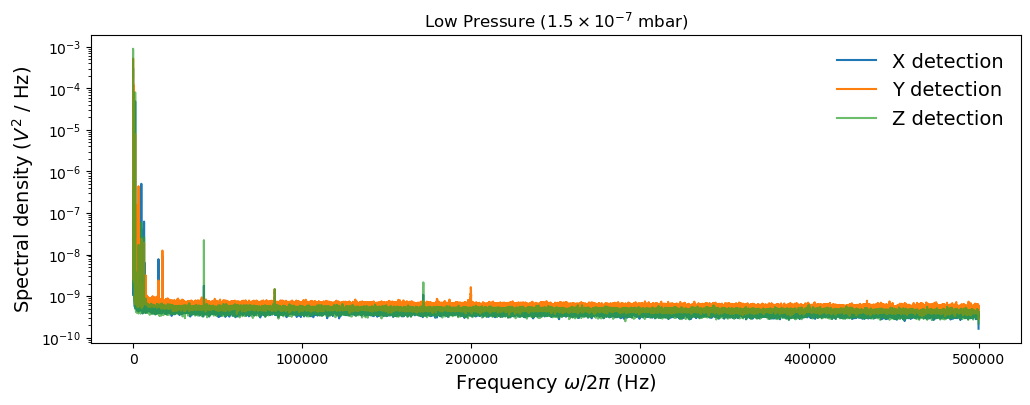

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ffx, ppx, label='X detection')
ax.plot(ffy, ppy, label='Y detection')
ax.plot(ffz, ppz, label='Z detection', alpha=0.7)

ax.set_title(r'Low Pressure ($1.5 \times 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$ / Hz)', fontsize=14)

ax.legend(frameon=False, fontsize=14)
ax.set_yscale('log')

## Drive the particle at 48 kHz, 0.5 V peak to peak

In [10]:
data_file = r"D:\Experiment\Calibration\20231118\drive_48khz_05v_5s.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 510394.647453682, central frequency: 41811.517076324366 Hz, gamma: 61.937757455918806 Hz


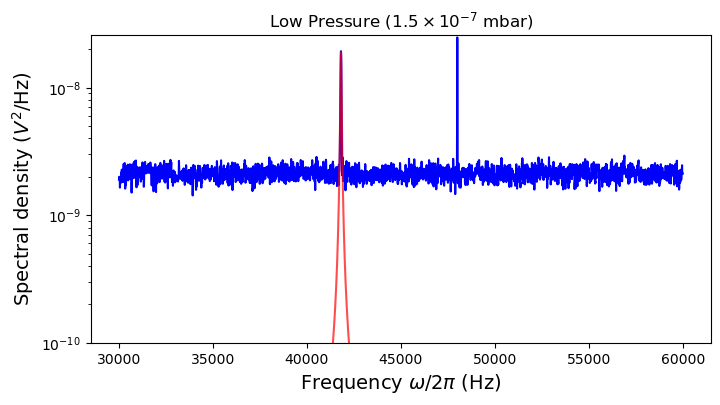

In [28]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub], 'b', label='Z detection')

# Fit with a Lorentzian and plot
lb_fit, ub_fit = 4100, 4250
popt, omega_fit, p_fit = fit_peak(ff[lb_fit:ub_fit]*2*np.pi, pp[lb_fit:ub_fit], peak_func, p0=[535, 42000*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit, 'r', alpha=0.7)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($1.5 \times 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$/Hz)', fontsize=14)

ax.set_ylim(1e-10)
ax.set_yscale('log')

Use the spectral density fit to calculate the calibration factor based on the response, assuming there is one charge on the sphere (calibrated at high pressure)

In [22]:
drive_amp = 0.5 # V; peak to peak
f_drive = 48000
omega_drive = f_drive * 2 * np.pi

# Electric force on the particle
charge = 1 * 1.6e-19
efield = 120          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero
f0 = charge * amp * efield

# Particle mass
rho = 2000 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

x2 = (f0**2 / (2 * m**2) ) / ((omega0_low**2 - omega_drive**2)**2 + gamma_low**2 * omega_drive**2)

In [24]:
v2_drive = get_peak_area(data, 1, f_drive)
c_cal_square = v2_drive / x2

print(f'Calibration factor square is {c_cal_square}.')

Calibration factor square is 321666641831892.25.


Plot the spectral density in terms of meters.

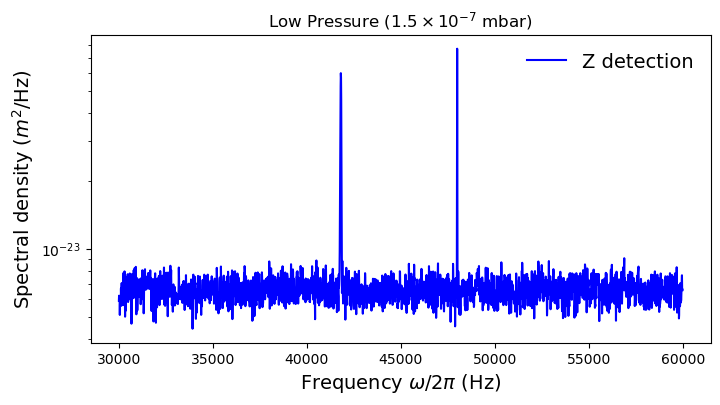

In [27]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub]/c_cal_square, 'b', label='Z detection')

ax.set_title(r'Low Pressure ($1.5 \times 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($m^2$/Hz)', fontsize=14)

ax.legend(frameon=False, fontsize=14)
ax.set_yscale('log')

## Frequency comb calibration

In [34]:
data_file = r"D:\Experiment\Calibration\20231118\noefield_1e-7_5s_after_freq_comb.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 721007.4086539376, central frequency: 42078.73917012865 Hz, gamma: 95.43631756587605 Hz


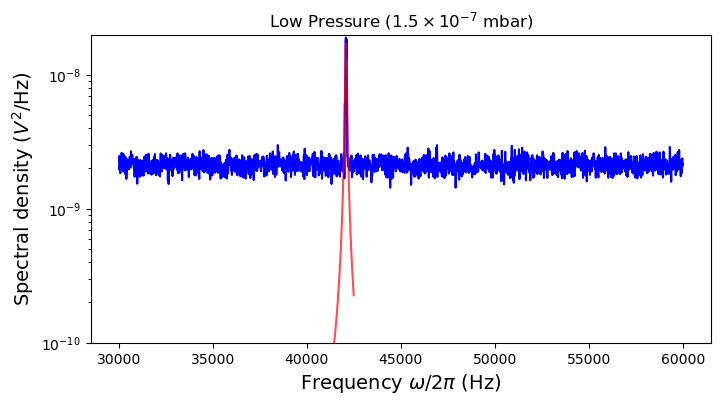

In [35]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub], 'b', label='Z detection')

# Fit with a Lorentzian and plot
lb_fit, ub_fit = 4100, 4250
popt, omega_fit, p_fit = fit_peak(ff[lb_fit:ub_fit]*2*np.pi, pp[lb_fit:ub_fit], peak_func, p0=[535, 42000*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit, 'r', alpha=0.7)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($1.5 \times 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$/Hz)', fontsize=14)

ax.set_ylim(1e-10)
ax.set_yscale('log')

In [29]:
data_file = r"D:\Experiment\Calibration\20231118\freq_comb_50s_20_70_2khz_lp_025vp2p.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

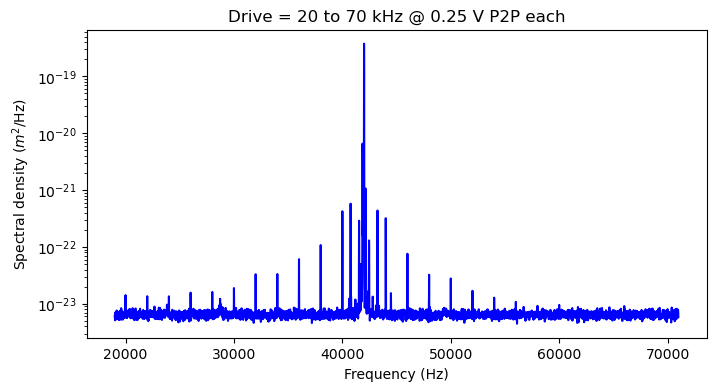

In [30]:
lb, ub = 1900, 7100
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub]/c_cal_square, 'b')

ax.set_title('Drive = 20 to 70 kHz @ 0.25 V P2P each')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($m^2$/Hz)')

ax.set_yscale('log')

In [31]:
drive_amp = 0.25  # peak-to-peak voltage for each freq component in V
freq_comb_file = r"C:\Users\microspheres\Documents\Python Scripts\Experiment Control\freq_comb_20khz_70khz_deltaf2khz.npz"

comb_data = np.load(freq_comb_file, allow_pickle=True)
ff_drive = comb_data['ff']

In [32]:
charge = 1 * 1.6e-19
efield = 120          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero
f0 = charge * amp * efield

chisquare = np.zeros_like(ff_drive, dtype=np.float64)
for i, f in enumerate(ff_drive):
    v2_drive = get_peak_area(data, 1, f)
    x2_drive = v2_drive / c_cal_square
    
    chisquare_drive = 2 * x2_drive / (f0**2)
    chisquare[i] = chisquare_drive

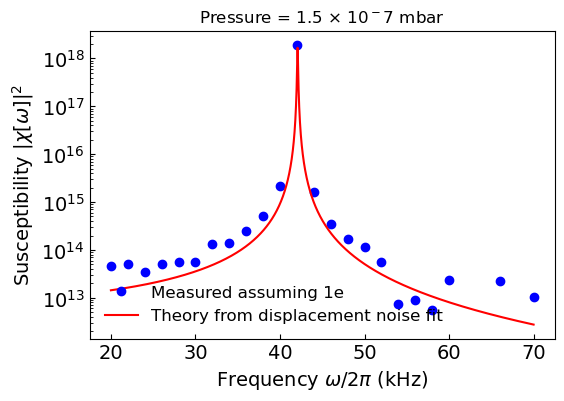

In [38]:
lb, ub = 2000, 7000

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ff_drive/1000, chisquare, 'bo', label='Measured assuming 1e')
ax.plot(ff[lb:ub]/1000, peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), 'r', label='Theory from displacement noise fit')

ax.set_title(r'Pressure = 1.5 $\times$ 10$^-7$ mbar')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'Susceptibility $| \chi[\omega] |^2$', fontsize=14)
ax.legend(loc='lower left', frameon=False, fontsize=12)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_yscale('log')

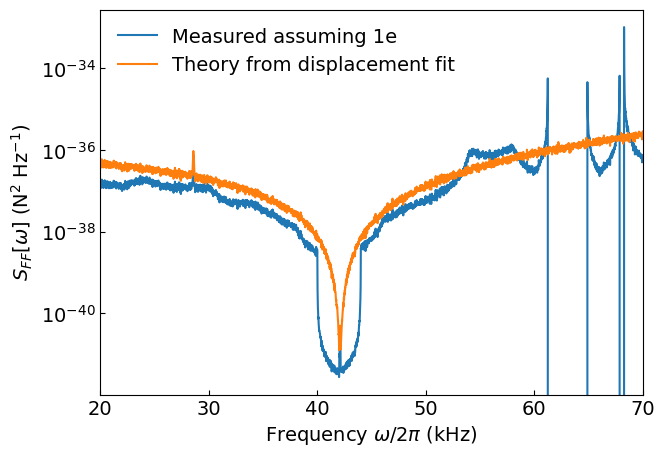

In [39]:
fig, ax = plt.subplots(figsize=(7, 5))

lb, ub = 2000, 7001
sxx = pp / c_cal_square
sff = sxx[lb:ub] / np.interp(ff[lb:ub], ff_drive, chisquare)

ax.plot(ff[lb:ub] / 1000, sff, label='Measured assuming 1e')
ax.plot(ff[lb:ub] / 1000, sxx[lb:ub] / peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), label='Theory from displacement fit')

ax.set_xlim(20, 70)
# ax.set_ylim(1e-41, 1e-34)

ax.set_yscale('log')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'$S_{FF}[\omega]$ (N$^2$ Hz$^{-1}$)', fontsize=14)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.legend(frameon=False, fontsize=14)

## New detection setup
Add ND filters to improve stability

In [113]:
data_file = r"D:\Experiment\Calibration\20231118\noefield_1e-7_5s_new_detection.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 2692685.6030911063, central frequency: 41803.17746941926 Hz, gamma: 39.795182769650694 Hz


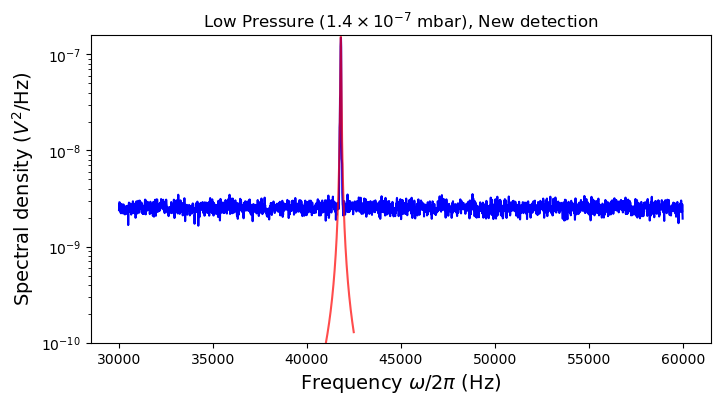

In [114]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub], 'b', label='Z detection')

# Fit with a Lorentzian and plot
lb_fit, ub_fit = 4100, 4250
popt, omega_fit, p_fit = fit_peak(ff[lb_fit:ub_fit]*2*np.pi, pp[lb_fit:ub_fit], peak_func, p0=[535, 42000*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit, 'r', alpha=0.7)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($1.4 \times 10^{-7}$ mbar), New detection')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$/Hz)', fontsize=14)

ax.set_ylim(1e-10)
ax.set_yscale('log')

In [115]:
data_file = r"D:\Experiment\Calibration\20231118\drive_48khz_05v_5s_2.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 1561467.1264190185, central frequency: 41547.33173346472 Hz, gamma: 89.1577234281364 Hz


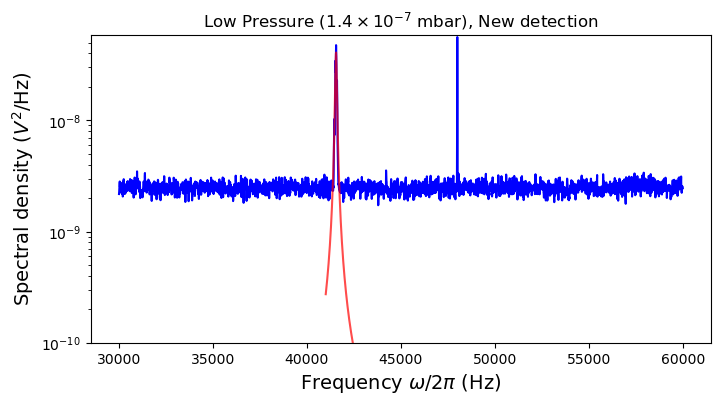

In [116]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub], 'b', label='Z detection')

# Fit with a Lorentzian and plot
lb_fit, ub_fit = 4100, 4250
popt, omega_fit, p_fit = fit_peak(ff[lb_fit:ub_fit]*2*np.pi, pp[lb_fit:ub_fit], peak_func, p0=[535, 42000*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit, 'r', alpha=0.7)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($1.4 \times 10^{-7}$ mbar), New detection')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$/Hz)', fontsize=14)

ax.set_ylim(1e-10)
ax.set_yscale('log')

In [117]:
drive_amp = 0.5 # V; peak to peak
f_drive = 48000
omega_drive = f_drive * 2 * np.pi

# Electric force on the particle
charge = 1 * 1.6e-19
efield = 120          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero
f0 = charge * amp * efield

# Particle mass
rho = 2000 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

x2 = (f0**2 / (2 * m**2) ) / ((omega0_low**2 - omega_drive**2)**2 + gamma_low**2 * omega_drive**2)

In [118]:
v2_drive = get_peak_area(data, 1, f_drive)
c_cal_square = v2_drive / x2

print(f'Calibration factor square is {c_cal_square}.')

Calibration factor square is 873281920520807.6.


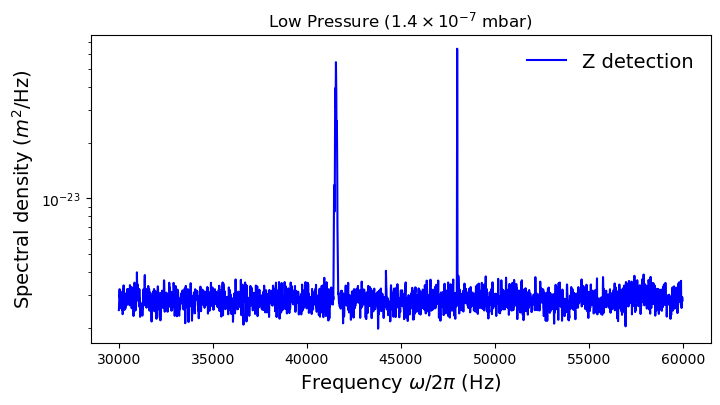

In [119]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub]/c_cal_square, 'b', label='Z detection')

ax.set_title(r'Low Pressure ($1.4 \times 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($m^2$/Hz)', fontsize=14)

ax.legend(frameon=False, fontsize=14)
ax.set_yscale('log')

In [120]:
data_file = r"D:\Experiment\Calibration\20231118\noefield_1e-7_5s_new_detection_2.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 1573998.274350791, central frequency: 41539.14538218612 Hz, gamma: 46.25344445477587 Hz


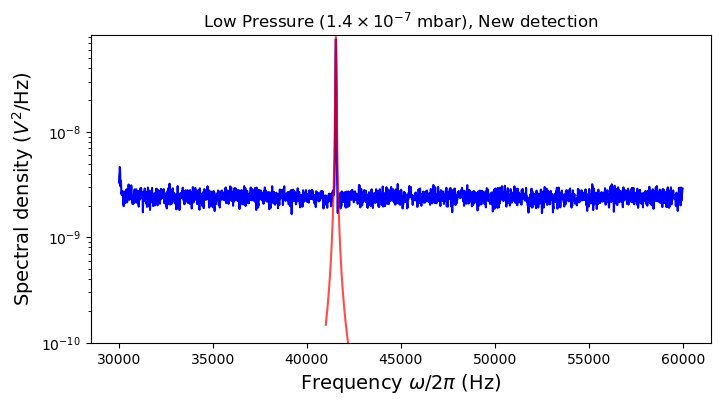

In [121]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub], 'b', label='Z detection')

# Fit with a Lorentzian and plot
lb_fit, ub_fit = 4100, 4250
popt, omega_fit, p_fit = fit_peak(ff[lb_fit:ub_fit]*2*np.pi, pp[lb_fit:ub_fit], peak_func, p0=[535, 42000*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit, 'r', alpha=0.7)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($1.4 \times 10^{-7}$ mbar), New detection')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$/Hz)', fontsize=14)

ax.set_ylim(1e-10)
ax.set_yscale('log')

In [122]:
data_file = r"D:\Experiment\Calibration\20231118\freq_comb_50s_20_70_2khz_lp_025vp2p_2.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

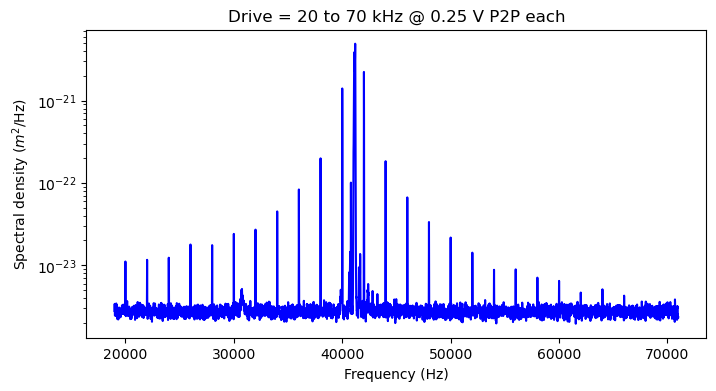

In [123]:
lb, ub = 1900, 7100
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub]/c_cal_square, 'b')

ax.set_title('Drive = 20 to 70 kHz @ 0.25 V P2P each')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($m^2$/Hz)')

ax.set_yscale('log')

In [124]:
drive_amp = 0.25  # peak-to-peak voltage for each freq component in V
freq_comb_file = r"C:\Users\microspheres\Documents\Python Scripts\Experiment Control\freq_comb_20khz_70khz_deltaf2khz.npz"

comb_data = np.load(freq_comb_file, allow_pickle=True)
ff_drive = comb_data['ff']

In [125]:
charge = 1 * 1.6e-19
efield = 120          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero
f0 = charge * amp * efield

chisquare = np.zeros_like(ff_drive, dtype=np.float64)
for i, f in enumerate(ff_drive):
    v2_drive = get_peak_area(data, 1, f)
    x2_drive = v2_drive / c_cal_square
    
    chisquare_drive = 2 * x2_drive / (f0**2)
    chisquare[i] = chisquare_drive

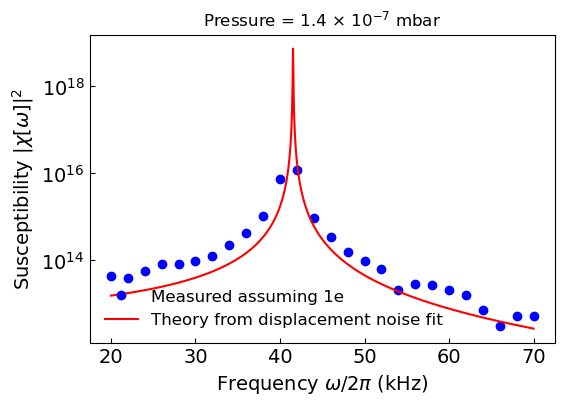

In [126]:
lb, ub = 2000, 7000

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ff_drive/1000, chisquare, 'bo', label='Measured assuming 1e')
ax.plot(ff[lb:ub]/1000, peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), 'r', label='Theory from displacement noise fit')

ax.set_title(r'Pressure = 1.4 $\times$ 10$^{-7}$ mbar')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'Susceptibility $| \chi[\omega] |^2$', fontsize=14)
ax.legend(loc='lower left', frameon=False, fontsize=12)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_yscale('log')

Calculate the expected momentum senstivity

In [75]:
data_file = r"D:\Experiment\Calibration\20231118\noefield_1e-7_5s_new_detection_2.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 1573998.274350791, central frequency: 41539.14538218612 Hz, gamma: 46.25344445477587 Hz


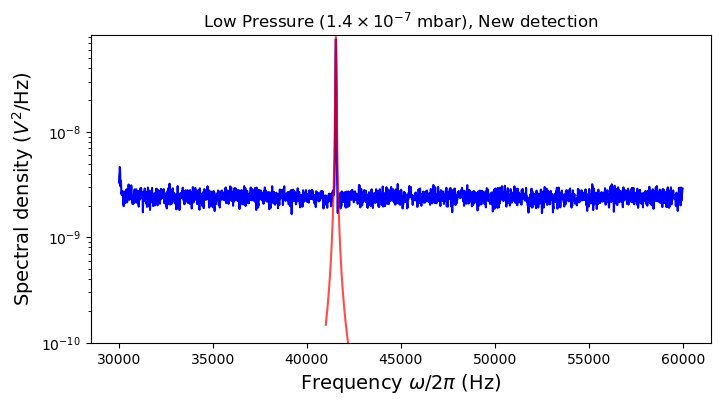

In [76]:
lb, ub = 3000, 6000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub], 'b', label='Z detection')

# Fit with a Lorentzian and plot
lb_fit, ub_fit = 4100, 4250
popt, omega_fit, p_fit = fit_peak(ff[lb_fit:ub_fit]*2*np.pi, pp[lb_fit:ub_fit], peak_func, p0=[535, 42000*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit, 'r', alpha=0.7)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($1.4 \times 10^{-7}$ mbar), New detection')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$/Hz)', fontsize=14)

ax.set_ylim(1e-10)
ax.set_yscale('log')

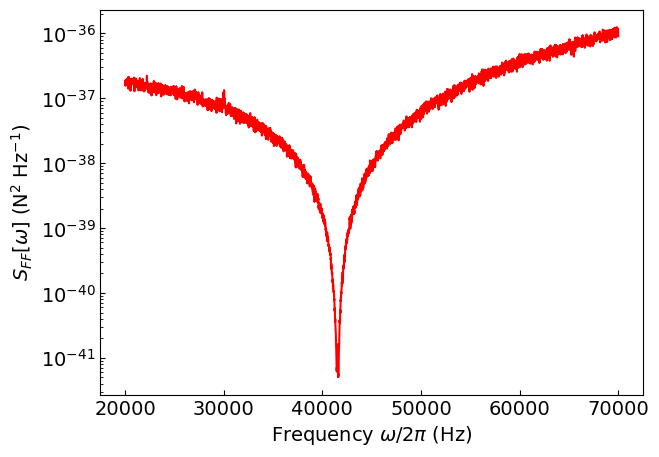

In [99]:
fig, ax = plt.subplots(figsize=(7, 5))

sff_theory = sxx / peak_func(ff*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low)

lb, ub = 2000, 7001
ax.plot(ff[lb:ub], sff_theory[lb:ub], 'r')
ax.set_yscale('log')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel(r'$S_{FF}[\omega]$ (N$^2$ Hz$^{-1}$)', fontsize=14)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

In [105]:
chi_disp_fit = peak_func(ff*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low)

In [107]:
integrand = (1 / (2*np.pi)) * np.abs(chi_disp_fit) * np.abs(chi_disp_fit) / (sxx)

In [108]:
SI2ev * 0.5 * np.sqrt(1 / np.trapz(y=integrand, x=ff*2*np.pi))

0.00013773810333105542

In [85]:
c = 299792458    # m / s
SI2ev = (1 / 1.6e-19) * c

delta_p_expected = SI2ev * 2 * np.pi / ( np.trapz(1/sff_theory[lb:ub], ff[lb:ub]*2*np.pi) )
print(f'Expected momentum sensitivity is {delta_p_expected / 1000} keV.')

Expected momentum sensitivity is 3.4844108322347727e-20 keV.


In [41]:
# Electric force on the particle
charge = 1 * 1.6e-19
efield = 120          # V/m when 1 V is applied
amp = 1   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero
f0 = charge * amp * efield

In [46]:
f0 * 2e-6 * SI2ev

71950.18991999999